In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
with open("data/notMNIST.pickle", "rb") as f:
    dataset = pickle.load(f)
print(dataset.keys())


for k, v in dataset.items():
    print(k, v.shape)

locals().update(dataset)
del dataset
#train_labels.shape = (len(train_labels), 1)
#test_labels.shape = (len(test_labels), 1)
#valid_labels.shape = (len(valid_labels), 1)


feature_num = train_dataset.shape[1] * train_dataset.shape[2]

dict_keys(['train_labels', 'valid_dataset', 'test_labels', 'valid_labels', 'train_dataset', 'test_dataset'])
train_labels (50000,)
valid_dataset (10000, 28, 28)
test_labels (10000,)
valid_labels (10000,)
train_dataset (50000, 28, 28)
test_dataset (10000, 28, 28)


In [3]:
from sklearn import preprocessing

features_num = 28*28
oneHotEncoder = preprocessing.OneHotEncoder()

def reformat(dataset, labels):
    num = dataset.shape[0]
    dataset = np.reshape(dataset, newshape=(num, features_num)).astype(np.float32)
    labels = np.reshape(labels, newshape=(num, 1))
    y = oneHotEncoder.fit_transform(labels).toarray().astype(np.float32)
    return dataset, labels, y

train_dataset, train_labels, train_y = reformat(train_dataset, train_labels)
valid_dataset, valid_labels, valid_y = reformat(valid_dataset, valid_labels)
test_dataset, test_labels, test_y = reformat(test_dataset, test_labels)

print(train_y.shape, np.sum(train_y, axis=0))
print(valid_y.shape, np.sum(valid_y, axis=0))
print(test_y.shape, np.sum(test_y, axis=0))

(50000, 10) [ 4952.  5012.  5045.  4986.  5052.  5019.  5031.  4948.  5005.  4950.]
(10000, 10) [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]
(10000, 10) [ 1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.  1000.]


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
batch_size = 128

class NN(object):
    def __init__(self, layer_sizes):
        self.weights = []
        self.biases = []
        for i in range(len(layer_sizes)-1):
            input_sz = layer_sizes[i]
            output_sz = layer_sizes[i+1]
            weights = tf.Variable(tf.truncated_normal([input_sz, output_sz]))
            biases = tf.Variable(tf.zeros([output_sz]))
            self.weights.append(weights)
            self.biases.append(biases)
            
    def get_logits(self, X, dropout_rate=None):
        for i in range(len(self.weights)):
            weights = self.weights[i]
            biases = self.biases[i]
            logits = tf.matmul(X, weights) + biases
            if dropout_rate is not None:
                logits = tf.nn.dropout(logits, dropout_rate)
            X = tf.nn.relu(logits)
        return logits
    
    def get_regularization_param(self):
        return sum(tf.nn.l2_loss(weights) for weights in self.weights)

def TryTraining(layers, num_steps, freq, learning_rate,
                regularization_rate=None, dropout_rate=None, learning_decay_rate=None,
                gradient_clipping=False):
    valid_accuracy = np.zeros([int(num_steps/freq)])
    
    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 28*28))
        tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, 10))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        global_step = tf.Variable(0)
        if learning_decay_rate is None:
            tf_learning_rate = learning_rate
        else:
            tf_learning_rate = tf.train.exponential_decay(
                learning_rate=learning_rate,
                global_step=global_step,
                decay_steps=1000,
                decay_rate=learning_decay_rate)


        nn = NN(layers)

        layer1_logits = nn.get_logits(tf_train_dataset, dropout_rate=dropout_rate)
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(layer1_logits, tf_train_y))
        if regularization_rate is not None:
            regularization_param = nn.get_regularization_param()
            loss += regularization_rate * regularization_param

        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        if gradient_clipping:
            gradients = optimizer.compute_gradients(loss)
            
            def ClipIfNotNone(grad):
                if grad is None:
                    return grad
                return tf.clip_by_value(grad, -1, 1)
            clipped_gradients = [(ClipIfNotNone(grad), var) for grad, var in gradients]
            opt = optimizer.apply_gradients(clipped_gradients, global_step=global_step)
        else:
            opt = optimizer.minimize(loss, global_step=global_step)

        train_prediction = tf.nn.softmax(layer1_logits)
        valid_prediction = tf.nn.softmax(nn.get_logits(tf_valid_dataset))
        test_prediction = tf.nn.softmax(nn.get_logits(tf_test_dataset))
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')

        for step in range(num_steps):
            offset = (step * batch_size) % (train_y.shape[0] - batch_size)
            batch_data = train_dataset[offset:offset+batch_size]
            batch_y = train_y[offset:offset+batch_size]
            feed_dict = {
                tf_train_dataset: batch_data,
                tf_train_y: batch_y,
            }
            _, l, predictions = session.run([opt, loss, train_prediction], feed_dict=feed_dict)
            if (step % freq) == 1:
                valid_accuracy[int(step/freq)] = accuracy(valid_prediction.eval(), valid_y)

            if (step % 500) == 0:
                print('Loss at step %d: %f' % (step, l))
                #print('Training accuracy: %.1f%%' % accuracy(predictions, batch_y))
        print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_y))
        #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_y))

    plt.plot(valid_accuracy)
    plt.figure(figsize=(10,10))
    plt.show()

Initialized
Loss at step 0: 12.964008
Loss at step 500: 2.270380
Loss at step 1000: 0.529760
Loss at step 1500: 0.857488
Loss at step 2000: 0.916729
Loss at step 2500: 0.969137
Loss at step 3000: 0.904657
Validation accuracy: 78.5%


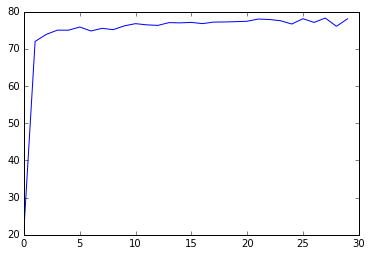

In [6]:
TryTraining(
    layers=[28*28, 10],
    num_steps=3001,
    freq=100,
    learning_rate=0.5,
    regularization_rate=None)

Initialized
Loss at step 0: 194.925400
Loss at step 500: 15.200276
Loss at step 1000: 4.063701
Loss at step 1500: 2.985816
Loss at step 2000: 3.987104
Loss at step 2500: 2.343935
Loss at step 3000: 2.896843
Validation accuracy: 80.0%


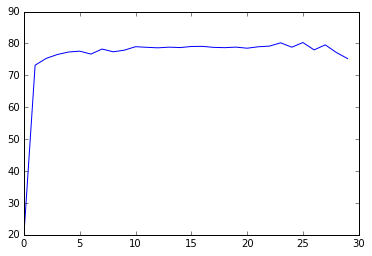

In [7]:
TryTraining(
    layers=[28*28, 300, 10],
    num_steps=3001,
    freq=100,
    learning_rate=0.05,
    regularization_rate=None)

Initialized
Loss at step 0: 1092.774536
Loss at step 500: 564.962341
Loss at step 1000: 336.404114
Loss at step 1500: 203.905655
Loss at step 2000: 123.262093
Loss at step 2500: 74.922379
Loss at step 3000: 45.570152
Validation accuracy: 83.6%


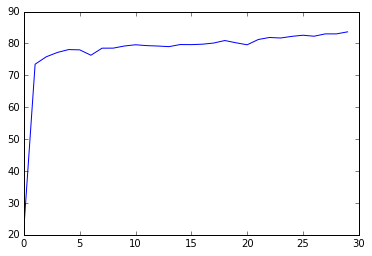

In [8]:
TryTraining(
    layers=[28*28, 300, 10],
    num_steps=3001,
    freq=100,
    learning_rate=0.05,
    regularization_rate=0.01)

Initialized
Loss at step 0: 1109.984619
Loss at step 500: 563.473083
Loss at step 1000: 336.474640
Loss at step 1500: 203.431625
Loss at step 2000: 123.164917
Loss at step 2500: 74.798798
Loss at step 3000: 45.535839
Loss at step 3500: 27.911345
Loss at step 4000: 17.152798
Loss at step 4500: 10.685183
Loss at step 5000: 6.614392
Validation accuracy: 84.9%


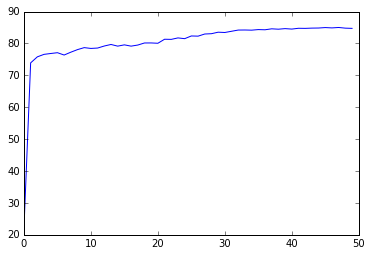

In [12]:
TryTraining(
    layers=[28*28, 300, 10],
    num_steps=5001,
    freq=100,
    learning_rate=0.05,
    learning_decay_rate=0.5,
    regularization_rate=0.01,
    gradient_clipping=True)

Initialized
Loss at step 0: 178639.328125
Loss at step 500: 159.565292
Loss at step 1000: 4.142546
Loss at step 1500: 2.318361
Loss at step 2000: 2.303584
Loss at step 2500: 2.309941
Loss at step 3000: 2.305756
Loss at step 3500: 2.310710
Loss at step 4000: 2.312810
Loss at step 4500: 2.298338
Loss at step 5000: 2.320262
Loss at step 5500: 2.325629
Loss at step 6000: 2.307915
Loss at step 6500: 2.302291
Loss at step 7000: 2.311888
Loss at step 7500: 2.296334
Loss at step 8000: 2.297393
Loss at step 8500: 2.309229
Loss at step 9000: 2.293929
Loss at step 9500: 2.324457
Loss at step 10000: 2.298567
Validation accuracy: 10.0%


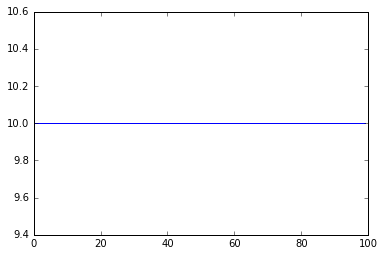

In [11]:
TryTraining(
    layers=[28*28, 1024, 300, 50, 10],
    num_steps=10001,
    freq=100,
    learning_rate=0.5,
    dropout_rate=0.25,
    learning_decay_rate=0.5,
    regularization_rate=0.01,
    gradient_clipping=True)